In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ripple_detection.simulate import simulate_LFP, simulate_time

In [3]:
SAMPLING_FREQUENCY = 1000
n_samples = SAMPLING_FREQUENCY * 3
time = simulate_time(n_samples, SAMPLING_FREQUENCY)
lfp = simulate_LFP(time, [1.1, 2.1], noise_amplitude=1.2, ripple_amplitude=1.5)
LFPs = lfp.copy()[:, np.newaxis]

Visualize ripple filter

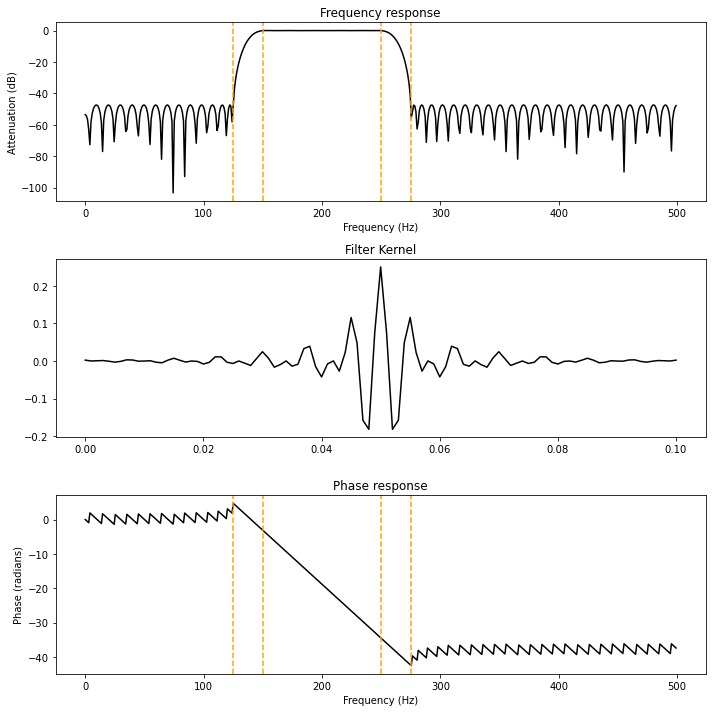

In [4]:
import scipy.signal
from ripple_detection.core import ripple_bandpass_filter

filter_numerator, filter_denominator = ripple_bandpass_filter(SAMPLING_FREQUENCY)

normalized_frequency, h = scipy.signal.freqz(filter_numerator, filter_denominator)
frequency = normalized_frequency * SAMPLING_FREQUENCY / (2. * np.pi)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))


axes[0].plot(frequency,
         20 * np.log10(np.abs(h)), color='black')
axes[0].set_title('Frequency response')
axes[0].set_ylabel('Attenuation (dB)')
axes[0].set_xlabel('Frequency (Hz)');
axes[0].axvline(125, color='orange', linestyle='--')
axes[0].axvline(150, color='orange', linestyle='--')
axes[0].axvline(250, color='orange', linestyle='--')
axes[0].axvline(275, color='orange', linestyle='--')

axes[1].plot(np.arange(filter_numerator.size) / SAMPLING_FREQUENCY, filter_numerator, color='black')
axes[1].set_title('Filter Kernel');

h_phase = np.unwrap(np.arctan2(h.imag, h.real))
axes[2].plot(frequency, h_phase, color='black')
axes[2].set_ylabel('Phase (radians)')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_title('Phase response')
axes[2].axvline(125, color='orange', linestyle='--')
axes[2].axvline(150, color='orange', linestyle='--')
axes[2].axvline(250, color='orange', linestyle='--')
axes[2].axvline(275, color='orange', linestyle='--')

plt.tight_layout()

## Karlsson Method

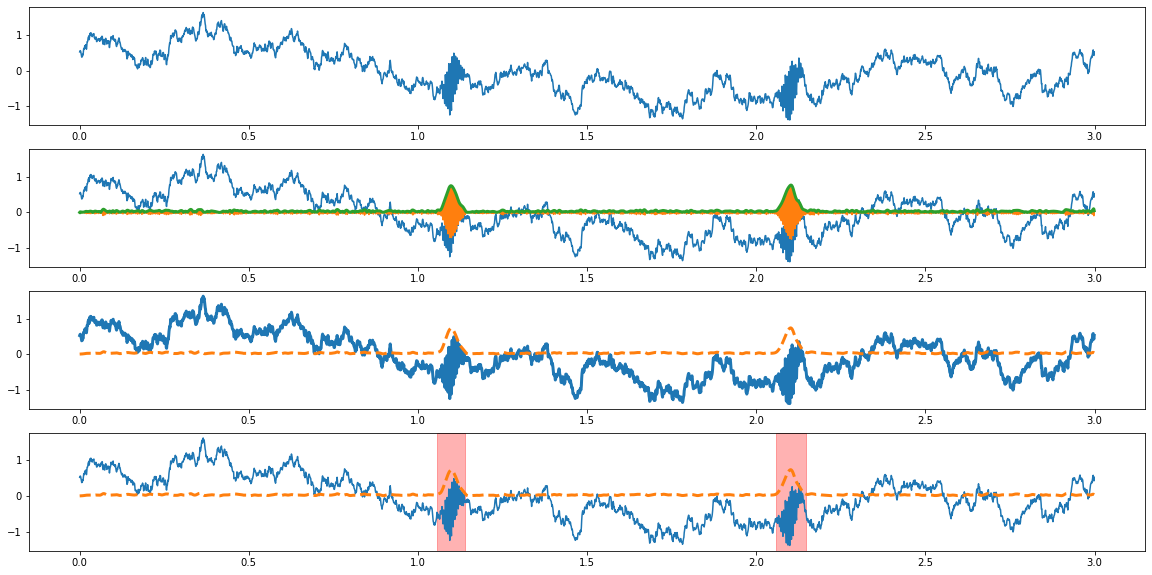

In [5]:
from ripple_detection.core import (filter_ripple_band, get_envelope,
                                   gaussian_smooth, threshold_by_zscore)

smoothing_sigma = 0.004
minimum_duration = 0.015
zscore_threshold = 3

is_nan = np.isnan(lfp)
filtered_lfp = filter_ripple_band(
    lfp[~is_nan].squeeze(), sampling_frequency=SAMPLING_FREQUENCY)
envelope = get_envelope(filtered_lfp)
smoothed_envelope = gaussian_smooth(
    envelope, sigma=smoothing_sigma,
    sampling_frequency=SAMPLING_FREQUENCY)

lfp_ripple_times = threshold_by_zscore(
    smoothed_envelope, time[~is_nan], minimum_duration,
    zscore_threshold)

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
ax[0].plot(time, lfp);
ax[1].plot(time, lfp);
ax[1].plot(time, filtered_lfp);
ax[1].plot(time, envelope, linewidth=3)
ax[2].plot(time, lfp, linewidth=3)
ax[2].plot(time, smoothed_envelope, linestyle='--', linewidth=3);
ax[3].plot(time, lfp);
ax[3].plot(time, smoothed_envelope, linestyle='--', linewidth=3);
for start_time, end_time in lfp_ripple_times:
    ax[3].axvspan(start_time, end_time, alpha=0.3, color='red')

## Kay Method

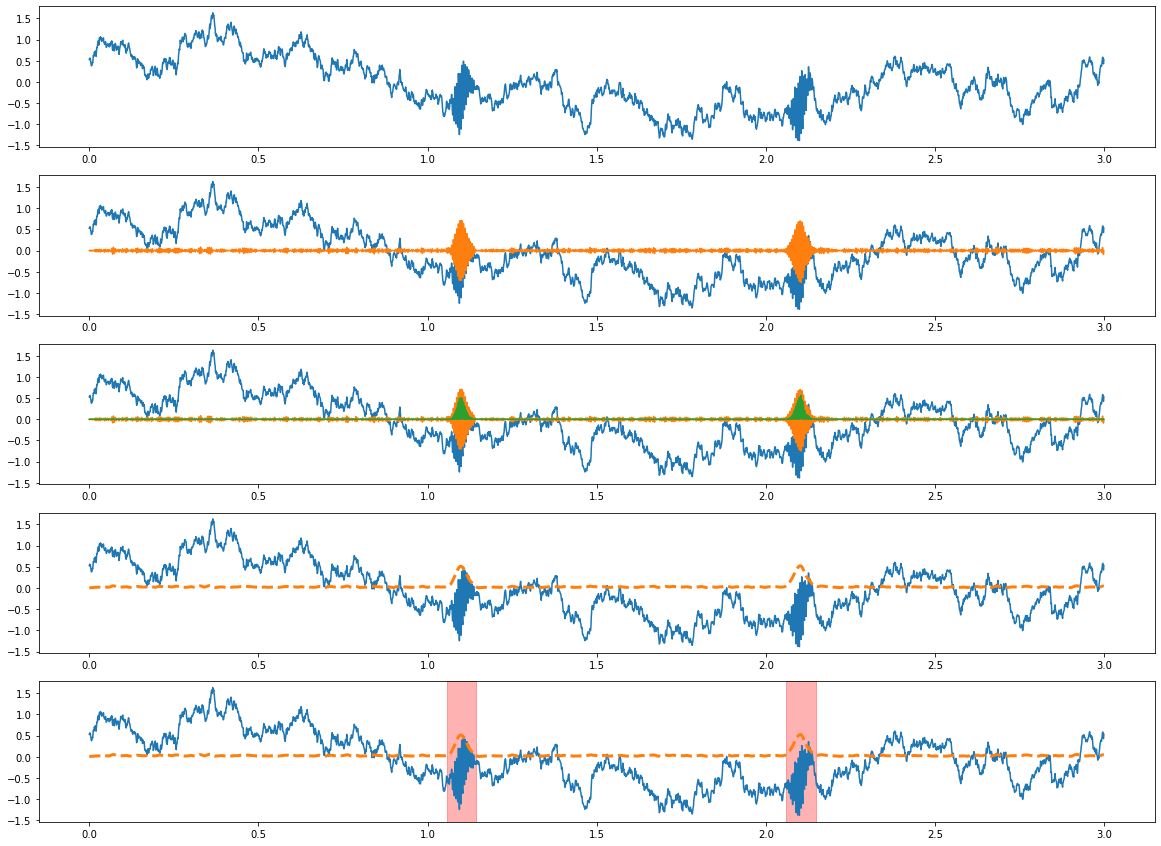

In [6]:
smoothing_sigma = 0.004
minimum_duration = 0.015
zscore_threshold = 3

filtered_lfps = np.stack([
    filter_ripple_band(lfp.squeeze(),
                       sampling_frequency=SAMPLING_FREQUENCY)
    for lfp in LFPs.T])

sum_squared_filtered_lfps = np.nansum(get_envelope(filtered_lfps) ** 2, axis=0)
combined_filtered_lfps = np.sqrt(
    gaussian_smooth(sum_squared_filtered_lfps,
                    sigma=smoothing_sigma,
                    sampling_frequency=SAMPLING_FREQUENCY))
candidate_ripple_times = threshold_by_zscore(
    combined_filtered_lfps, time, minimum_duration, zscore_threshold)


fig, ax = plt.subplots(5, 1, figsize=(20, 15))
ax[0].plot(time, lfp);
ax[1].plot(time, lfp);
ax[1].plot(time, filtered_lfps[0]);
ax[2].plot(time, lfp);
ax[2].plot(time, filtered_lfps[0]);
ax[2].plot(time, sum_squared_filtered_lfps)
ax[3].plot(time, lfp);
ax[3].plot(time, combined_filtered_lfps, linestyle='--', linewidth=3)
ax[4].plot(time, lfp);
ax[4].plot(time, combined_filtered_lfps, linestyle='--', linewidth=3)
for start_time, end_time in candidate_ripple_times:
    ax[4].axvspan(start_time, end_time, alpha=0.3, color='red')

##### 